# Group 16 Milestone 1

In [94]:
import os
import os.path
import zipfile
import requests
import json
import pandas as pd
from urllib.request import urlretrieve
import glob
import re
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Necessary metadata
url = "https://api.figshare.com/v2/articles/14096681"
headers = {"Content-Type": "application/json"}
output_directory = "../data/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

In [3]:
%%time
files_to_dl = "data.zip"
if not os.path.isfile(output_directory + files_to_dl):
    for file in files:
        if file["name"] == files_to_dl:
            os.makedirs(output_directory, exist_ok=True)
            urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 187 µs, sys: 109 µs, total: 296 µs
Wall time: 268 µs


In [4]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, files_to_dl), "r") as f:
    f.extractall(output_directory)
os.remove("../data/observed_daily_rainfall_SYD.csv")

CPU times: user 14.6 s, sys: 891 ms, total: 15.5 s
Wall time: 16.7 s


In [6]:
%%time
files = glob.glob("../data/*.csv")
columns = ["time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
df = pd.concat((pd.read_csv(file, index_col=0, usecols=columns)
                .assign(model=re.findall(r"[^\/]+(?=\_daily)", file)[0])
                for file in files)
              )

CPU times: user 39.1 s, sys: 4.25 s, total: 43.4 s
Wall time: 45.1 s


In [7]:
df

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM
...,...,...,...,...,...,...
2014-12-27 12:00:00,-30.157068,-29.214660,153.1250,154.3750,6.689683e+00,SAM0-UNICON
2014-12-28 12:00:00,-30.157068,-29.214660,153.1250,154.3750,7.862555e+00,SAM0-UNICON
2014-12-29 12:00:00,-30.157068,-29.214660,153.1250,154.3750,1.000503e+01,SAM0-UNICON


## Runtimes of CSV compilation


| Team Member | OS           | RAM | Processor        | Is SSD | Wall Time Taken |
|-------------|--------------|-----|------------------|--------|-----------------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    | 1min 32s        |
| Margot      |              |     |                  |        |                 |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |         45.1s        |
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |     1min 40s         |

## EDA for Python

### Combine Data into a Single CSV Using Python Pandas.

In [8]:
%%time
df.to_csv(os.path.join(output_directory, "combined_csv.csv"))

CPU times: user 5min 23s, sys: 4.68 s, total: 5min 28s
Wall time: 5min 32s


### Load Combined CSV File into Memory and Perform EDA

In [97]:
%%time
df_baseline = pd.read_csv(os.path.join(output_directory, "combined_csv.csv"), parse_dates=True)

CPU times: user 41.7 s, sys: 13 s, total: 54.7 s
Wall time: 1min 52s


#### EDA

#### Structure of the Data

In [98]:
# check dtype and memory usage
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.3+ GB


In [99]:
df_baseline.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


#### Summary Statistics For Each Numeric Columns

In [100]:
%%time
df_baseline.describe()

CPU times: user 6.43 s, sys: 4.33 s, total: 10.8 s
Wall time: 13 s


,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


#### Counts of a Numeric Column

In [101]:
%%time
df_baseline['lat_min'].value_counts()

CPU times: user 484 ms, sys: 116 ms, total: 600 ms
Wall time: 642 ms


-34.869110    3035329
-31.099476    3035329
-32.041885    3035329
-32.984293    3035329
-30.000000    1747830
               ...   
-33.487232     183960
-30.696652     183960
-36.281964     183960
-33.490981     183960
-30.700015     183960
Name: lat_min, Length: 84, dtype: int64

#### Histogram Showing the Counts of Minimum Latitude

(array([2070450., 6347269., 1610490.,  966420., 4691449., 2806470.,
         644070., 4185079., 4509420.,  367920., 4921129.,  644280.,
        2806530., 4921339., 1610700., 2484330., 3955129., 1748520.,
        2070210., 5887339.]),
 array([-36.46738961, -36.13902013, -35.81065065, -35.48228117,
        -35.15391169, -34.82554221, -34.49717273, -34.16880325,
        -33.84043377, -33.51206429, -33.18369481, -32.85532533,
        -32.52695584, -32.19858636, -31.87021688, -31.5418474 ,
        -31.21347792, -30.88510844, -30.55673896, -30.22836948,
        -29.9       ]),
 <BarContainer object of 20 artists>)

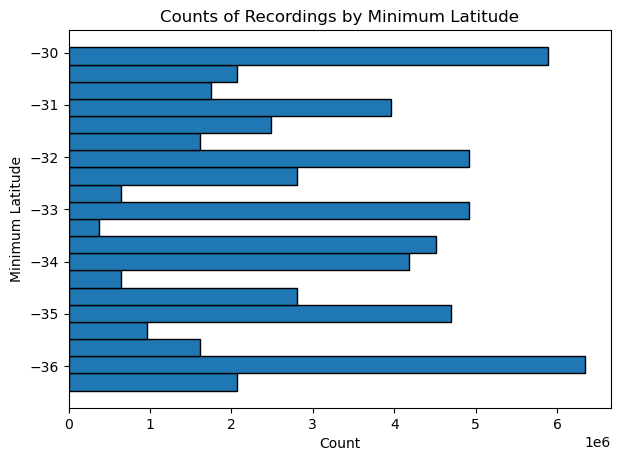

In [123]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('Counts of Recordings by Minimum Latitude')
plt.xlabel('Count')
plt.ylabel('Minimum Latitude')
plt.hist(df_baseline['lat_min'], bins = 20, 
         stacked=True, orientation='horizontal', ec='black')

#### Counts of Different Models

In [102]:
%%time
model_valuecount = df_baseline['model'].value_counts()
model_valuecount

CPU times: user 3.18 s, sys: 161 ms, total: 3.34 s
Wall time: 3.45 s


MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

#### Histogram Showing the Counts of Recordings by Model Type

(array([ 966420.,  966420.,  919800., 1932840., 3219300., 3541230.,
        3037320., 3219300., 3035340., 3037320., 3541230.,  966420.,
         966420., 1610700., 1287720., 1609650., 5154240., 3541230.,
        3541230., 3541230., 1287720., 1609650., 2070900.,  551880.,
        3219300.,  551880., 3541153.]),
 array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
         4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
         9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
        14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
        19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
        24.07407407, 25.03703704, 26.        ]),
 <BarContainer object of 27 artists>)

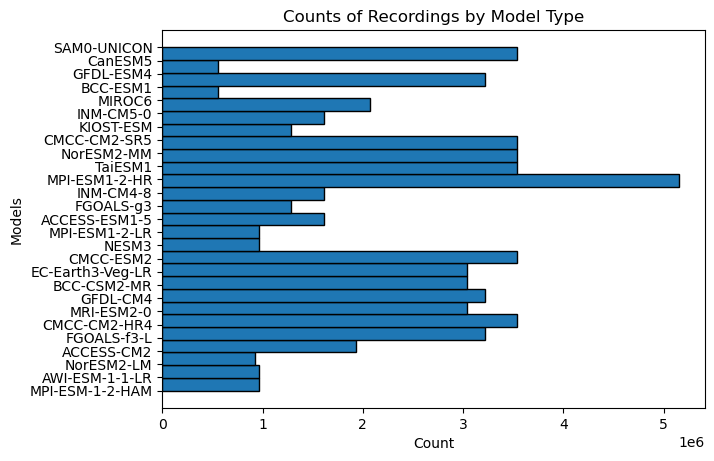

In [122]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('Counts of Recordings by Model Type')
plt.xlabel('Count')
plt.ylabel('Models')
plt.hist(df_baseline['model'], bins=len(model_valuecount), 
         stacked=True, orientation='horizontal', ec='black')

#### Run times comparison for baseline data loading and EDA

| Team Member | OS  | RAM | Processor        | Is SSD | Time (loading) |  Time (EDA numeric column)| Time (EDA categorical column)|
|-------------|--------------|-----|------------------|--------|-----------------|------|------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    |      |      |       |
| Margot      |              |     |                  |        |                 |   |   |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |   1 min 13s  | 850ms |4.23s|
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |            |   |   |

## Investigating approaches to reduce memory usage.

### 1. Changing `dtype` of data

#### Data Loading and Set `dtype`

In [124]:
%%time
dtype_columns = {"lat_min": 'float16',
                 "lat_max": 'float16',
                 "lon_min": 'float16', 
                 "lon_max": 'float16', 
                 "rain (mm/day)": 'float16',
                 "model": 'str'
                }
df_dtype = pd.read_csv(os.path.join(output_directory, "combined_csv.csv"), index_col=0, 
                   parse_dates=True, dtype=dtype_columns)

CPU times: user 49 s, sys: 7.56 s, total: 56.5 s
Wall time: 1min 17s


#### EDA

### Structure of the Data

In [125]:
# check dtype and memory usage
df_dtype.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   lat_min        float16
 1   lat_max        float16
 2   lon_min        float16
 3   lon_max        float16
 4   rain (mm/day)  float16
 5   model          object 
dtypes: float16(5), object(1)
memory usage: 1.5+ GB


In [126]:
df_dtype.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM


#### Counts of a Numeric Column

In [127]:
%%time
df_dtype['lat_min'].value_counts()

CPU times: user 562 ms, sys: 177 ms, total: 739 ms
Wall time: 842 ms


-34.87500    3035329
-30.15625    3035329
-33.93750    3035329
-32.96875    3035329
-32.03125    3035329
              ...   
-30.37500     321930
-32.40625     321930
-34.43750     321930
-34.09375     229950
-30.31250     229950
Name: lat_min, Length: 61, dtype: int64

#### Counts of Different Models

In [128]:
%%time
df_dtype['model'].value_counts()

CPU times: user 3.16 s, sys: 128 ms, total: 3.28 s
Wall time: 3.36 s


MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

#### Run times comparison for data loading with changed dtype and EDA

| Team Member | OS  | RAM | Processor        | Is SSD | Time (loading) |  Time (EDA numeric column)| Time (EDA categorical column)|
|-------------|--------------|-----|------------------|--------|-----------------|------|------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    |      |      |       |
| Margot      |              |     |                  |        |                 |   |   |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |   1 min 1s  | 706ms |3.58s|
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |            |   |   |

### 2. Load just columns we want

#### Select Columns and Load Data

In [129]:
%%time
# Only select 1 numeric column and 1 string type column

cols = ["lat_min", "model"]
df_selected_cols = pd.read_csv(os.path.join(output_directory, "combined_csv.csv"), 
                   parse_dates=True, usecols=cols)

CPU times: user 23.5 s, sys: 2.02 s, total: 25.5 s
Wall time: 33.7 s


#### EDA

#### Structure of the Data

In [130]:
# check dtype and memory usage
df_selected_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   lat_min  float64
 1   model    object 
dtypes: float64(1), object(1)
memory usage: 953.2+ MB


In [131]:
df_selected_cols.head()

,lat_min,model
0,-35.439867,MPI-ESM-1-2-HAM
1,-35.439867,MPI-ESM-1-2-HAM
2,-35.439867,MPI-ESM-1-2-HAM
3,-35.439867,MPI-ESM-1-2-HAM
4,-35.439867,MPI-ESM-1-2-HAM


#### Counts of a Numeric Column

In [132]:
%%time
df_selected_cols['lat_min'].value_counts()

CPU times: user 488 ms, sys: 109 ms, total: 598 ms
Wall time: 632 ms


-34.869110    3035329
-31.099476    3035329
-32.041885    3035329
-32.984293    3035329
-30.000000    1747830
               ...   
-33.487232     183960
-30.696652     183960
-36.281964     183960
-33.490981     183960
-30.700015     183960
Name: lat_min, Length: 84, dtype: int64

#### Counts of Different Models

In [133]:
%%time
df_selected_cols['model'].value_counts()

CPU times: user 3.15 s, sys: 22.9 ms, total: 3.17 s
Wall time: 3.17 s


MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

#### Run times comparison for data loading with only selected columns and EDA

| Team Member | OS  | RAM | Processor        | Is SSD | Time (loading) |  Time (EDA numeric column)| Time (EDA categorical column)|
|-------------|--------------|-----|------------------|--------|-----------------|------|------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    |      |      |       |
| Margot      |              |     |                  |        |                 |   |   |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |   26.4s  | 640ms |3.16s|
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |            |   |   |

### 3. Load in chunks

#### EDA

#### Counts of a Numeric Column

In [134]:
%%time

counts = pd.Series(dtype=int)
for chunk in pd.read_csv(os.path.join(output_directory, "combined_csv.csv"), chunksize=100_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int64
CPU times: user 45.7 s, sys: 5.33 s, total: 51 s
Wall time: 52.9 s


#### Counts of Different Models

In [135]:
%%time

counts = pd.Series(dtype=int)
for chunk in pd.read_csv(os.path.join(output_directory, "combined_csv.csv"), chunksize=100_000):
    counts = counts.add(chunk["lat_min"].value_counts(), fill_value=0)
print(counts.astype(int))

-36.467390     644280
-36.455696     321930
-36.420966     414180
-36.281964     183960
-36.277805     183960
               ...   
-30.157068    1011769
-30.157068    1517670
-30.000000    1747830
-29.921967     644280
-29.900000     459900
Length: 84, dtype: int64
CPU times: user 43.8 s, sys: 5.15 s, total: 48.9 s
Wall time: 50.2 s


#### Run times comparison for data loading in chunks and EDA

| Team Member | OS  | RAM | Processor        | Is SSD |Time (loading & EDA numeric column)| Time (loading & EDA categorical column)|
|-------------|--------------|-----|------------------|--------|-----------------|------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    |      |      |
| Margot      |              |     |                  |        |                 |   |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |  50.8s | 49.3s |
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |            |   |

### 4. Dask

#### Loading the Data as Dask Data Frame

In [136]:
%%time
df_dask = dd.read_csv(os.path.join(output_directory, "combined_csv.csv"))

CPU times: user 6.99 ms, sys: 16.1 ms, total: 23.1 ms
Wall time: 118 ms


### EDA

#### Structure of the Data

In [137]:
# check dtype
df_dask.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 7 entries, time to model
dtypes: object(2), float64(5)

In [151]:
# memory usage by column (unit: bytes)
mem_col = df_dask.memory_usage(deep=True).compute()
mem_col

Index                 11904
lat_max           499742744
lat_min           499742744
lon_max           499742744
lon_min           499742744
model            4213929314
rain (mm/day)     499742744
time             4735966588
dtype: int64

In [152]:
# memory usage by column (unit: GB)
round(mem_col/10**9, 2)

Index            0.00
lat_max          0.50
lat_min          0.50
lon_max          0.50
lon_min          0.50
model            4.21
rain (mm/day)    0.50
time             4.74
dtype: float64

In [144]:
# memory usage by partition
mem_par = df_dask.memory_usage_per_partition(deep=True).compute()
mem_par

0     105930420
1     105775532
2     106455301
3     116533040
4     120592919
        ...    
88    111857592
89    112380520
90    113285800
91    112768024
92    111726216
Length: 93, dtype: int64

In [150]:
print(f"Total memory usage {round(mem_par.sum()/10**9, 1)}GB")

Total memory usage 11.4GB


In [138]:
df_dask.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


#### Counts of a Numeric Column

In [139]:
%%time
df_dask['lat_min'].value_counts().compute()

CPU times: user 28.9 s, sys: 5.28 s, total: 34.2 s
Wall time: 13.2 s


-31.099476    3035329
-32.984293    3035329
-34.869110    3035329
-32.041885    3035329
-30.000000    1747830
               ...   
-30.696652     183960
-36.277805     183960
-36.281964     183960
-30.700015     183960
-33.487232     183960
Name: lat_min, Length: 84, dtype: int64

#### Counts of Different Models

In [140]:
%%time
df_dask['model'].value_counts().compute()

CPU times: user 31.6 s, sys: 4.71 s, total: 36.3 s
Wall time: 14.4 s


MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

#### Run times comparison for data loading with Dask and EDA

| Team Member | OS  | RAM | Processor        | Is SSD | Time (loading) |  Time (EDA numeric column)| Time (EDA categorical column)|
|-------------|--------------|-----|------------------|--------|-----------------|------|------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    |      |      |       |
| Margot      |              |     |                  |        |                 |   |   |
| Thea Wenxin |   MacOS Monterey |  16GB   |   Apple M1 chip |  Yes    |   27.3s  | 7.87s |12.3s|
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |            |   |   |

### Summary of Different Methods to Reduce Memory Usage and Run Times

- The memory usage with baseline method (load the whole combined CSV file with `pandas.read_csv` ) is 3.3+ GB. The memory loading time is the highest among all methods. 
- Changing the data type of numeric columns to `dtype` with smaller memory usage can reduce half of the memory in this case. However the run time for loading and EDA on numeric and categorical columns only slightly decreased. But, we will compromise the precision on data.
- Load only selected columns could largely decrease the memory usage and loading time, however only slightly decrease the run time for those selected columns.
- Loading and processing data in chunks can decrease the overall run time compare with the baseline. It could be considered as an alternative to the baseline method.
- The highest memory usage among all four methods is 11.4 GB with Dask Dataframe. However, the the loading time is at the lower side compared with baseline. The reason is that it c

## EDA for R

In [7]:
%load_ext rpy2.ipython

**In order to select which method is the most appropriate to transfer the dataframe from python to R, we chose to try all methods and observe which method was more suitable for us (the code and output of the methods that were not selected are placed in markdown cells):**

### Parquet Method

```
%%time
df.to_parquet("../data/rainfall.parquet")

>>> CPU times: user 22.3 s, sys: 5.77 s, total: 28.1 s
Wall time: 30.1 s
```
<br/><br/>

```
%%time
%%R
library(dplyr)
library(arrow)
parquet_rdf <- read_parquet("../data/rainfall.parquet") |> collect()

>>> CPU times: user 4.42 s, sys: 4.37 s, total: 8.8 s
Wall time: 8.37 s
```

### Feather Method

```
%%time
import pyarrow.feather as feather
feather.write_feather(df, '../data/rainfall.feather')

>>> CPU times: user 4.5 s, sys: 4.45 s, total: 8.95 s
Wall time: 6.89 s
```
<br/><br/>

```
%%time
%%R
feather_rdf <- read_feather("../data/rainfall.feather") |> collect()

>>> CPU times: user 1.09 s, sys: 1.84 s, total: 2.93 s
Wall time: 4.31 s
```

### Arrow Exchange Method

In [12]:
import rpy2.robjects.conversion
import pyarrow
import rpy2.rinterface
import rpy2_arrow.pyarrow_rarrow as pyra
from rpy2.robjects.packages import importr


In [13]:
%%time
arrow_rframe = pyra.converter.py2rpy(pyarrow.Table.from_pandas(df))

CPU times: user 5.52 s, sys: 3.72 s, total: 9.24 s
Wall time: 8.7 s


In [14]:
%%time
%%R -i arrow_rframe
library(dplyr)
arrow_rframe <- arrow_rframe |> collect()

CPU times: user 4.97 ms, sys: 8.38 ms, total: 13.3 ms
Wall time: 20.6 ms


### Checking size of different files

In [15]:
b = 0
for file in files:
    b = os.path.getsize(file)
    b += b
b * 1e-6

666.979758

In [16]:
os.path.getsize("../data/rainfall.feather")*1e-6

716.238154

In [17]:
os.path.getsize("../data/rainfall.parquet")*1e-6

701.2660629999999

**Summary of different transfer methods:**


| Method | Estimated time to transfer | File memory |
| --- | --- | --- |
| Arrow Exchange | 9s | 667 MB |
| Feather file | 11s | 716 MB |
| Parquet file | 27s | 701 MB |

**Justification:** The 'Arrow Exchange' method appeared to speed up the conversion of a pandas DataFrame into tabular data that is accessible for R. We opted for this method since it decreases the time spent during the serialization and de-serialization process while also avoiding the creation of unnecessary copies of the data. In addition to this, the file storage format appears to be slightly less memory-intensive compared to the other file storage formats. Altogether, the 'Arrow Exchange' method appeared to be the most appropriate for our purposes.

### EDA

**Structure of the Data:**

In [26]:
%%R
str(arrow_rframe)

tibble [62,467,843 × 7] (S3: tbl_df/tbl/data.frame)
 $ lat_min      : num [1:62467843] -35.4 -35.4 -35.4 -35.4 -35.4 ...
 $ lat_max      : num [1:62467843] -33.6 -33.6 -33.6 -33.6 -33.6 ...
 $ lon_min      : num [1:62467843] 142 142 142 142 142 ...
 $ lon_max      : num [1:62467843] 143 143 143 143 143 ...
 $ rain (mm/day): num [1:62467843] 4.24e-13 4.22e-13 4.50e-13 4.25e-13 4.27e-13 ...
 $ model        : chr [1:62467843] "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" ...
 $ time         : chr [1:62467843] "1889-01-01 12:00:00" "1889-01-02 12:00:00" "1889-01-03 12:00:00" "1889-01-04 12:00:00" ...


**Mean Rainfall (mm/day) Computed For Each Model**

In [27]:
%%R
library(dplyr)
arrow_rframe |> group_by(model) |> summarize(mean_rainfall = mean(`rain (mm/day)`)) |> arrange(desc(mean_rainfall))

# A tibble: 27 × 2
   model         mean_rainfall
   <chr>                 <dbl>
 1 INM-CM4-8              2.81
 2 INM-CM5-0              2.67
 3 CMCC-CM2-SR5           2.38
 4 MIROC6                 2.30
 5 CMCC-CM2-HR4           2.28
 6 CMCC-ESM2              2.27
 7 NorESM2-MM             2.23
 8 NorESM2-LM             2.23
 9 TaiESM1                2.22
10 ACCESS-ESM1-5          2.22
# … with 17 more rows


**Counts of Different Models:**

In [29]:
%%R
arrow_rframe |> count(model) |> arrange(desc(n))

# A tibble: 27 × 2
   model               n
   <chr>           <int>
 1 MPI-ESM1-2-HR 5154240
 2 CMCC-CM2-HR4  3541230
 3 CMCC-CM2-SR5  3541230
 4 CMCC-ESM2     3541230
 5 NorESM2-MM    3541230
 6 TaiESM1       3541230
 7 SAM0-UNICON   3541153
 8 FGOALS-f3-L   3219300
 9 GFDL-CM4      3219300
10 GFDL-ESM4     3219300
# … with 17 more rows


**Summary Statistics For Each Columns**

In [28]:
%%R
arrow_rframe |> summary()

    lat_min           lat_max          lon_min           lon_max     
 Min.   :-36       Min.   :-36.00   Min.   :141       Min.   :141.2  
 1st Qu.:-35       1st Qu.:-33.66   1st Qu.:143       1st Qu.:145.0  
 Median :-33       Median :-32.04   Median :147       Median :148.1  
 Mean   :-33       Mean   :-31.98   Mean   :147       Mean   :148.2  
 3rd Qu.:-31       3rd Qu.:-30.16   3rd Qu.:150       3rd Qu.:151.3  
 Max.   :-30       Max.   :-27.91   Max.   :154       Max.   :155.6  
 NA's   :3219300                    NA's   :3219300                  
 rain (mm/day)        model               time          
 Min.   :  0       Length:62467843    Length:62467843   
 1st Qu.:  0       Class :character   Class :character  
 Median :  0       Mode  :character   Mode  :character  
 Mean   :  2                                            
 3rd Qu.:  1                                            
 Max.   :433                                            
 NA's   :3219300                         